In [211]:
# importing the libraries 
!pip install dask
!pip install pyarrow
!pip install plotly
import dask
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import glob
import folium
import plotly.express as px
from dask.diagnostics import ProgressBar 
from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

# Dataset:
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to 2017. 

# Variables of the dataset:

ID - Unique identifier for the record.

Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

Date - Date when the incident occurred. this is sometimes a best estimate.

Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.

Primary Type - The primary description of the IUCR code.

Description - The secondary description of the IUCR code, a subcategory of the primary description.

Location Description - Description of the location where the incident occurred.

Arrest - Indicates whether an arrest was made.

Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.

District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.

Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.

X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

Year - Year the incident occurred.

Updated On - Date and time the record was last updated.

Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

# Load data files:

In [6]:
#Loading the four CSV files
from glob import glob
filenames=sorted(glob(os.path.join("Data","*.csv")))
filenames

['Data\\Chicago_Crimes_2001_to_2004.csv',
 'Data\\Chicago_Crimes_2005_to_2007.csv',
 'Data\\Chicago_Crimes_2008_to_2011.csv',
 'Data\\Chicago_Crimes_2012_to_2017.csv']

In [7]:
dask_all_file=dd.read_csv(filenames,error_bad_lines=False,assume_missing=True,dtype={'ID': np.int64,'PrimaryType': 'str','FBI Code': 'object','Beat': np.uint16,'IUCR': 'str','Latitude': 'object',
'Y Coordinate': 'object','Location': 'str'},  parse_dates=['Date'],infer_datetime_format=True)

# Overview of dataset:

In [8]:
dask_all_file

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
npartitions=33,,,,,,,,,,,,,,,,,,,,,,,
,float64,int64,object,datetime64[ns],object,object,object,object,object,bool,bool,uint16,float64,float64,float64,object,float64,object,float64,object,object,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
dask_all_file.dtypes

Unnamed: 0                     float64
ID                               int64
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                            uint16
District                       float64
Ward                           float64
Community Area                 float64
FBI Code                        object
X Coordinate                   float64
Y Coordinate                    object
Year                           float64
Updated On                      object
Latitude                        object
Longitude                      float64
Location                        object
dtype: object

In [10]:
dask_all_file.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,879.0,4786321,HM399414,2004-01-01 00:01:00,082XX S COLES AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,...,7.0,46.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,2544.0,4676906,HM278933,2003-03-01 00:00:00,004XX W 42ND PL,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,11.0,61.0,26,1173974.0,1876757.0,2003.0,04/15/2016 08:55:02 AM,41.817229156,-87.637328,"(41.817229156, -87.637328162)"
2,2919.0,4789749,HM402220,2004-06-20 11:00:00,025XX N KIMBALL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,...,35.0,22.0,20,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
3,2927.0,4789765,HM402058,2004-12-30 20:00:00,045XX W MONTANA ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,...,31.0,20.0,06,NaN,NaN,2004.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN
4,3302.0,4677901,HM275615,2003-05-01 01:00:00,111XX S NORMAL AVE,0841,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,...,34.0,49.0,06,1174948.0,1831051.0,2003.0,04/15/2016 08:55:02 AM,41.691784636,-87.635116,"(41.691784636, -87.635115968)"


# Data Cleaning:

## Drop unwanted columns:

**We found the following columns not useful for our data analysis, so we decided to drop them.**

In [11]:
columns_to_drop = ['Unnamed: 0','ID','Case Number','IUCR','X Coordinate','Y Coordinate','Updated On','Location' ]
dask_all_file1 = dask_all_file.drop(columns_to_drop, axis=1)

In [12]:
dask_all_file1.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area',
       'FBI Code', 'Year', 'Latitude', 'Longitude'],
      dtype='object')

## Persist DataFrame in memory:

**Persist is important because Dask DataFrame is lazy by default. It is often ideal to load, filter, and shuffle data once and keep this result in memory. Afterwards, each of the several complex queries can be based off of this in-memory data rather than have to repeat the full load-filter-shuffle process each time.**

*Source: "https://docs.dask.org/en/stable/dataframe-best-practices.html"*

In [13]:
# Persist the dataframe in memory
dask_all_file1 = dask_all_file1.persist()

b'Skipping line 210938: expected 23 fields, saw 24\n'
b'Skipping line 24743: expected 23 fields, saw 24\n'
b'Skipping line 132222: expected 23 fields, saw 41\n'


## Handle missing values:

In [14]:
missing_values = dask_all_file1.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Arrest    int64
Year        ...
dtype: int64
Dask Name: dataframe-sum-agg, 100 tasks

In [15]:
missing_count = ((missing_values / dask_all_file1.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Arrest    float64
Year          ...
dtype: float64
Dask Name: mul, 169 tasks

In [16]:
%%time
with ProgressBar():
#ProgressBar is a function provided out of the dask.diagnostics package which will display a progress bar in your terminal to let you know how far a long a particular task is while it’s executing.
    missing_count_pct = missing_count.compute()
missing_count_pct

[########################################] | 100% Completed |  2.5s
Wall time: 2.51 s


Date                    0.000000
Block                   0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.025059
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.001146
Ward                    8.817518
Community Area          8.841028
FBI Code                0.000000
Year                    0.000000
Latitude                1.329420
Longitude               1.329433
dtype: float64

## Drop rows with missing values:

**As we have around 7 million of records and percentage of missing in each column is extremely low (less than 10%), we decided to drop the missing instead of updating which is very expensive operation.**

In [17]:
%%time
rows_to_drop = list(missing_count_pct[(missing_count_pct > 0) & (missing_count_pct < 5)].index)
dask_all_file1 = dask_all_file1.dropna(subset=rows_to_drop)    

Wall time: 9.99 ms


In [18]:
dask_all_file1.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 15 entries, Date to Longitude
dtypes: datetime64[ns](1), object(6), bool(2), float64(5), uint16(1)

## Handle Duplicates

### Drop duplicate records

In [19]:
%%time
dask_all_file1 = dask_all_file1.drop_duplicates()

Wall time: 14.9 ms


In [20]:
%%time
with ProgressBar():
    dask_all_file1 = dask_all_file1.set_index('Date')

[########################################] | 100% Completed | 26.2s
Wall time: 26.2 s


# Writing to Parquet file and Loading DataFrame from Parquet file

**Dask DataFrame users are encouraged to store and load data using Parquet. Apache Parquet is a columnar binary format that is easy to split into multiple files (easier for parallel loading) and is generally much simpler to deal with.**

Source: https://docs.dask.org/en/stable/dataframe-best-practices.html

In [21]:
%%time
with ProgressBar():
    dask_all_file1.to_parquet('crimes-2001-2017.snappy.parq', compression='SNAPPY')

[########################################] | 100% Completed | 36.7s
Wall time: 36.8 s


In [22]:
%%time
crimes_df = dd.read_parquet('crimes-2001-2017.snappy.parq', index='Date')

Wall time: 26.5 ms


In [23]:
%%time
crimes_df = crimes_df.persist()

Wall time: 8 s


In [24]:
# dataframe structure
crimes_df

,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
npartitions=1,,,,,,,,,,,,,,
2001-01-01 00:00:00,object,object,object,object,bool,bool,uint16,float64,float64,float64,object,float64,object,float64
2017-01-18 10:12:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [25]:
%%time
crimes_df.head()

Wall time: 2.02 ms


,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
Date,,,,,,,,,,,,,,
2001-01-01,089XX S BRANDON AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,10.0,46.0,06,2001.0,41.733539408,-87.547156
2001-01-01,027XX W NELSON ST,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,1411,14.0,NaN,NaN,14,2001.0,41.936549915,-87.697098
2001-01-01,033XX W 64TH ST,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,823,8.0,15.0,66.0,06,2001.0,41.777203808,-87.705942
2001-01-01,057XX S JUSTINE ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,713,7.0,16.0,67.0,06,2001.0,41.789165627,-87.663084
2001-01-01,039XX S CALIFORNIA AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,912,9.0,12.0,58.0,20,2001.0,41.822690348,-87.694491


# Data Analysis

## Single Column analysis

### Column Year: Years with most criminal records

In [26]:
%%time
with ProgressBar():
    crime_by_year=crimes_df.groupby([crimes_df.index.year]).size().compute()
        
top_10_years = crime_by_year.nlargest(10).sort_values(axis=0,ascending=False)
top_10_years

[########################################] | 100% Completed |  0.8s
Wall time: 794 ms


Date
2001    481676
2002    469854
2003    468972
2005    448245
2006    443550
2007    434313
2008    419149
2009    385372
2004    383414
2010    367997
dtype: int64

### Column Primary Type: type of criminal action, which one was the most common

In [27]:
%%time
with ProgressBar():
    crime_count_by_type = crimes_df.groupby('Primary Type').size().compute()
 
top_10_crime_types = crime_count_by_type.nlargest(10).sort_values(axis=0,ascending=False)
top_10_crime_types

[########################################] | 100% Completed |  0.5s
Wall time: 518 ms


Primary Type
THEFT                  1262435
BATTERY                1114872
CRIMINAL DAMAGE         701857
NARCOTICS               656837
OTHER OFFENSE           376185
ASSAULT                 373118
BURGLARY                357618
MOTOR VEHICLE THEFT     286417
ROBBERY                 230824
DECEPTIVE PRACTICE      211106
dtype: int64

### Column Domestic: Rate of domestic criminal offenses vs non-domestic ones

### Column Arrest: Rate of criminal acts involving arrest

In [55]:
crime_by_year=dask_all_file.groupby('Year').size().compute()
top_10_years = crime_by_year.nlargest(10).sort_values(axis=0,ascending=True)
top_10_years

b'Skipping line 210938: expected 23 fields, saw 24\n'
b'Skipping line 24743: expected 23 fields, saw 24\n'
b'Skipping line 132222: expected 23 fields, saw 41\n'


Year
2004.0    388205
2005.0    455811
2003.0    475913
2002.0    490879
2001.0    568517
2007.0    621848
2010.0    700691
2009.0    783900
2006.0    794684
2008.0    852053
dtype: int64

### Columns Latitude, longitude: To add them on a map to determine which areas concentrate most of the criminality

In [26]:
# this can be in visualization

### Column District: Top 5 of most violent districts

In [27]:
crime_types_total=dask_all_file.groupby('Primary Type').size().compute()
top_10_crime_types = crime_types_total.nlargest(10).sort_values(axis=0,ascending=True)
top_10_crime_types

b'Skipping line 210938: expected 23 fields, saw 24\n'
b'Skipping line 24743: expected 23 fields, saw 24\n'
b'Skipping line 132222: expected 23 fields, saw 41\n'


Primary Type
DECEPTIVE PRACTICE      280931
ROBBERY                 300453
MOTOR VEHICLE THEFT     370548
BURGLARY                470958
ASSAULT                 481661
OTHER OFFENSE           491922
NARCOTICS               885431
CRIMINAL DAMAGE         923000
BATTERY                1442716
THEFT                  1640506
dtype: int64

## Analysis involving more than two categories

### Column Primary Type and Year: Year evolution of the top 5 most common criminal actions

### Column Districts and Year: How violence evolved thoughout the years in the top 5 most violent districts

# Data visualization:

- Top 10 locations by total crimes on those locations
- Top 10 primary types of crimes and their number of occurence
- Number of cases by type
- Comparing Arrested or Not
- Plot Arrested Rate
- Number of cases per Year vs Months (Can use heatmap and bar) (we can also do a stacked graph x=month, y=total crimes , color of stack representing primary type.)
- Crime count total [2001-2017]  Vs. Month of the year- Which month of the year the crime count is the highest?
      -- one more where we add primary type of crimes also in monthwise counts
- Crime count total [2001-2017]  Vs. Day of the week
- No. of Crime per year-month (Aggregate by Year and Month) - 12 months Rolling sum ? We can prove if the crime rate (or crimes) is increasing or decreasing over these years
- Plot the location on the map, - Most Common 10 Crime Places
- Plot no. of crimes by location - on map, locations where total crimes r higher?
- Mapping Theft Crime Locations

In [28]:
crimes_df.head()

,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude
Date,,,,,,,,,,,,,,
2001-01-01,089XX S BRANDON AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,424,4.0,10.0,46.0,06,2001.0,41.733539408,-87.547156
2001-01-01,027XX W NELSON ST,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,1411,14.0,NaN,NaN,14,2001.0,41.936549915,-87.697098
2001-01-01,033XX W 64TH ST,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,823,8.0,15.0,66.0,06,2001.0,41.777203808,-87.705942
2001-01-01,057XX S JUSTINE ST,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,False,713,7.0,16.0,67.0,06,2001.0,41.789165627,-87.663084
2001-01-01,039XX S CALIFORNIA AVE,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,False,912,9.0,12.0,58.0,20,2001.0,41.822690348,-87.694491


In [73]:
# get crime types
crime_types = crimes_df[['Primary Type']]

# get crime counts by primary type
crime_type_total = crimes_df.groupby('Primary Type').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes_df[['Primary Type', 'Arrest', 'Domestic']].groupby('Primary Type').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic    Total
Primary Type                                                
THEFT                              153923     28794  1262435
BATTERY                            256551    469246  1114872
CRIMINAL DAMAGE                     50069     52227   701857
NARCOTICS                          652800       230   656837
OTHER OFFENSE                       66106    109334   376185
ASSAULT                             88617     80567   373118
BURGLARY                            20565      2296   357618
MOTOR VEHICLE THEFT                 26199      1055   286417
ROBBERY                             22672      3677   230824
DECEPTIVE PRACTICE                  41079      2423   211106
CRIMINAL TRESPASS                  131197      5531   176431
PROSTITUTION                        63421         5    63675
WEAPONS VIOLATION                   48277       212    59955
PUBLIC PEACE VIOLATION              28621      2062    44387
OFFENSE INVOLVING CHILDR

## plot crimes by primary type counts

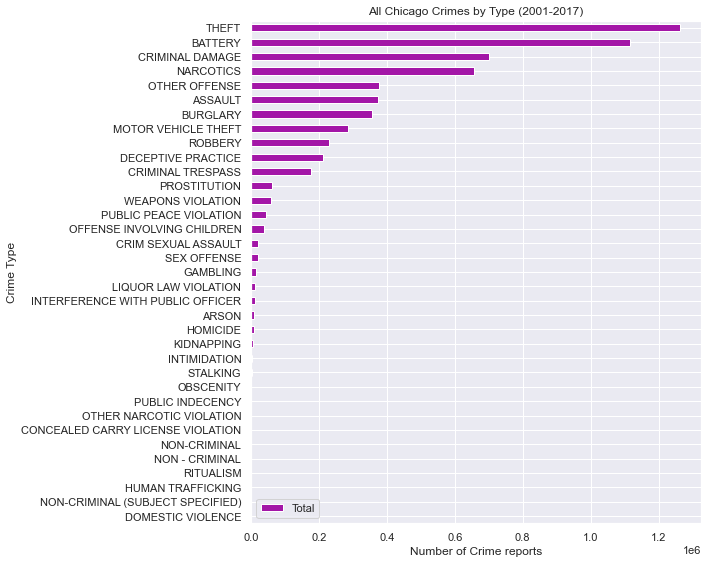

In [171]:
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True).drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(10,8), color='#A316A7')
plt.title('All Chicago Crimes by Type (2001-2017)')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

## Top 10 primary types of crimes and their number of occurences

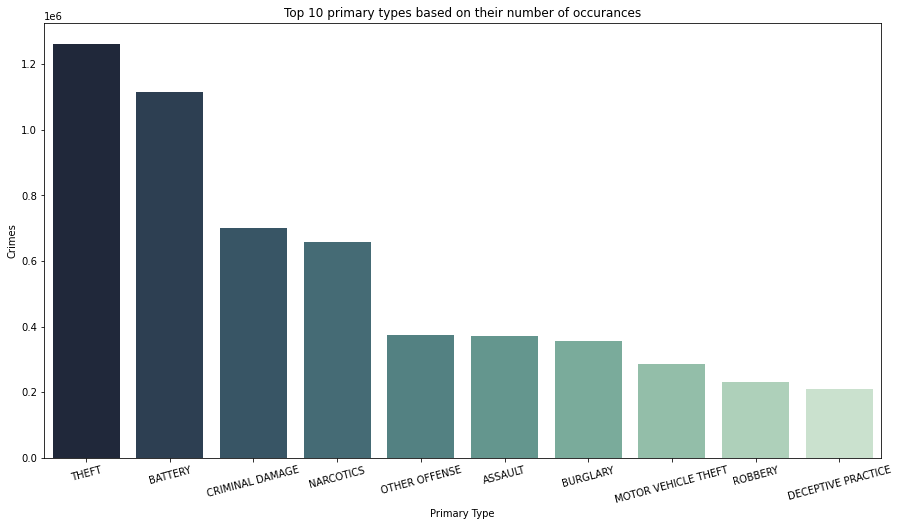

In [79]:
Prim_Type = crimes_df["Primary Type"]
Prim_Type2 = Counter(Prim_Type)
Top_Prim_Type = Prim_Type2.most_common(10)
x,y = zip(*Top_Prim_Type)
x,y  = list(x),list(y)
plt.figure(figsize=(15,8))
ax = sns.barplot(x=x, y=y, palette = sns.cubehelix_palette(len(x), rot=-.4, reverse=True))
plt.xticks(rotation= 15)
plt.title("Top 10 primary types based on their number of occurances")
plt.xlabel("Primary Type")
plt.ylabel("Crimes")
plt.show()

## Plot top crimes (>= 200,000 reports)

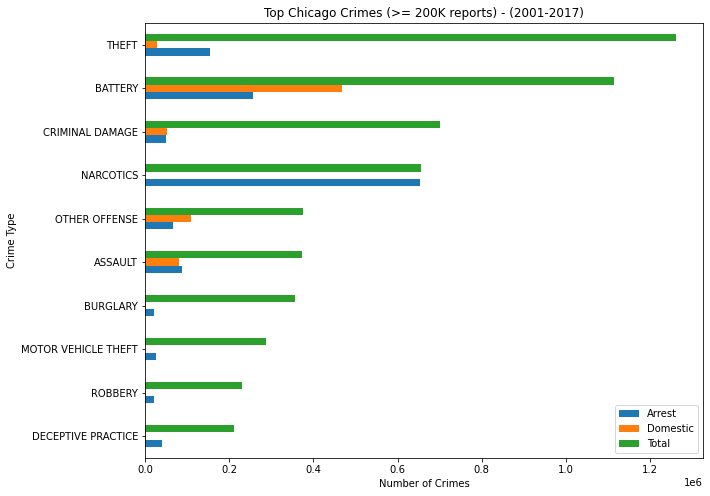

In [80]:
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True).plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports) - (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.show()

## Top 10 locations by no. of crimes (Based on Location Description)

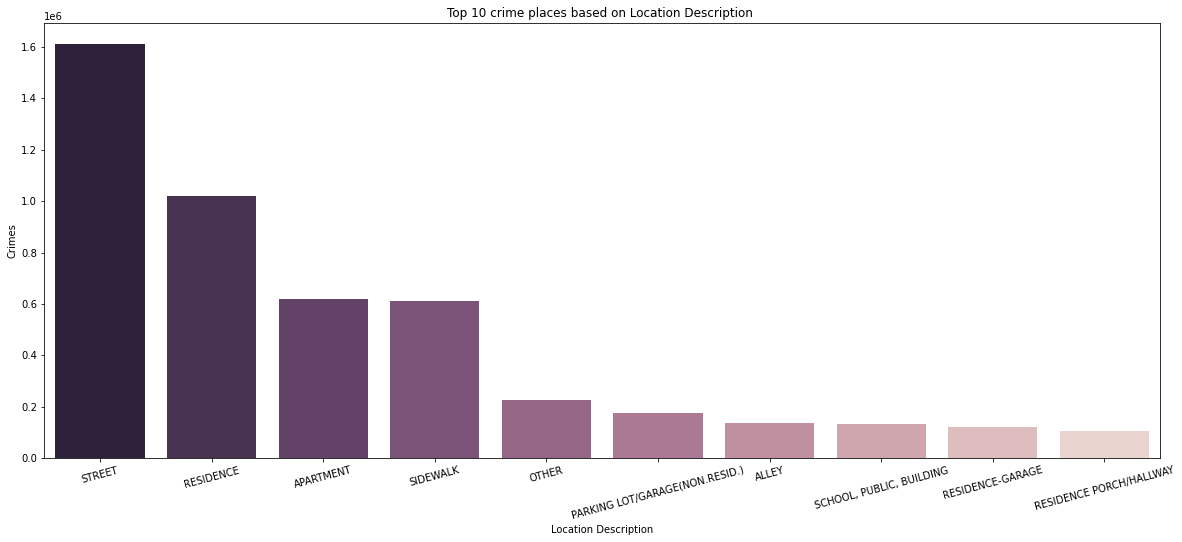

In [81]:
Loc_Desc = crimes_df["Location Description"]
counted = Counter(Loc_Desc) 
top_Loc_Desc = counted.most_common(10)
x,y = zip(*top_Loc_Desc)
x,y = list(x),list(y)
plt.figure(figsize = (20,8))
ax = sns.barplot(x = x , y = y, palette = sns.cubehelix_palette(len(x), reverse=True))
plt.xticks(rotation= 15)
plt.xlabel("Location Description")
plt.ylabel("Crimes")
plt.title("Top 10 crime places based on Location Description ")
plt.show()

## Get other offenses crimes

In [168]:
other_offenses = crimes_df[crimes_df['Primary Type']=='OTHER OFFENSE']
other_offense_crimes = other_offenses[['Primary Type', 'Description']].groupby('Description').count().compute().sort_values(by='Primary Type', ascending=False)
other_offense_crimes.head(10)

,Primary Type
Description,
TELEPHONE THREAT,124109
HARASSMENT BY TELEPHONE,92574
OTHER VEHICLE OFFENSE,32514
VIOLATE ORDER OF PROTECTION,29856
FALSE/STOLEN/ALTERED TRP,18566
HARASSMENT BY ELECTRONIC MEANS,18061
OTHER CRIME INVOLVING PROPERTY,10736
OTHER WEAPONS VIOLATION,6936
VEHICLE TITLE/REG OFFENSE,6147


## Plot top 20 other offense crimes

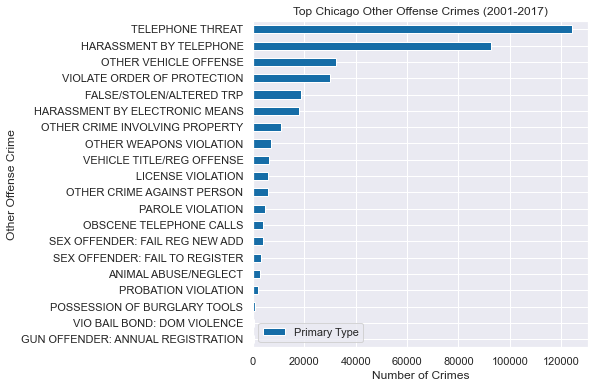

In [180]:
other_offense_crimes[:20].sort_values(by='Primary Type', ascending=True).plot(kind='barh', figsize=(6,6), color='#166DA7')
plt.title('Top Chicago Other Offense Crimes (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Other Offense Crime')
plt.show()

## Comparing Arrested or Not

In [82]:
Arrest = crimes_df["Arrest"]
Arrest2 = Counter(Arrest)
MostCommonCA = Arrest2.most_common()
x,y = zip(*MostCommonCA)
x,y = list(x),list(y)
x,y

([False, True], [4353457, 1715313])

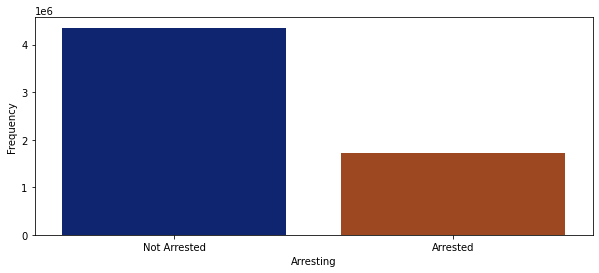

In [83]:
x[1] = "Arrested"
x[0] = "Not Arrested" 
plt.figure(figsize=(10,4))
sns.barplot(x = x , y = y , palette = "dark")
plt.xlabel("Arresting")
plt.ylabel("Frequency")
plt.show()

### Plot Arrested Rate

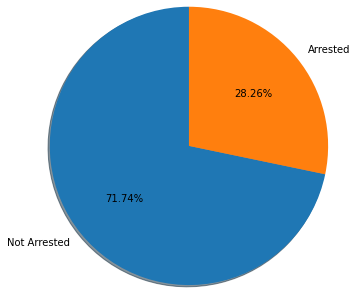

In [84]:
plt.pie(y,
        labels = x, 
        autopct = "%0.2f%%", # Show data in persentage for with 2 decimal point
        shadow = True, 
        startangle = 90,
        radius = 1.6,
       )
plt.show()

### Arrested rate per crime

In [174]:
rate_per_crime = crimes_df.groupby('Primary Type')['Arrest'].mean().reset_index()
rate_per_crime['Arrest (%)'] = rate_per_crime['Arrest'].round(4)*100
rate_per_crime.head(20)

,Primary Type,Arrest,Arrest (%)
0,ARSON,0.132592,13.26
1,ASSAULT,0.237504,23.75
2,BATTERY,0.230117,23.01
3,BURGLARY,0.057505,5.75
4,CONCEALED CARRY LICENSE VIOLATION,0.857143,85.71
5,CRIM SEXUAL ASSAULT,0.164421,16.44
6,CRIMINAL DAMAGE,0.071338,7.13
7,CRIMINAL TRESPASS,0.743616,74.36
8,DECEPTIVE PRACTICE,0.194589,19.46
9,DOMESTIC VIOLENCE,1.000000,100.00


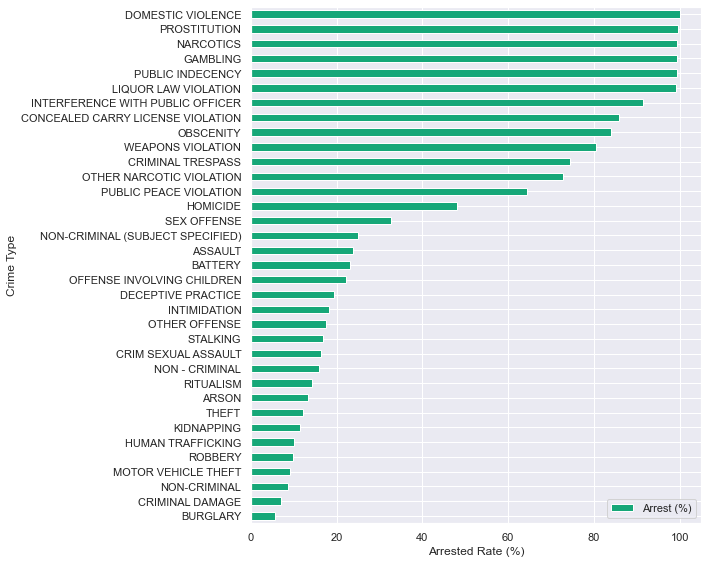

In [175]:
rate_per_crime = rate_per_crime.compute()
rate_per_crime = rate_per_crime.sort_values(by='Arrest (%)', ascending=True).drop(['Arrest'], axis=1) # denotes column
rate_per_crime.plot(x="Primary Type", y="Arrest (%)", kind='barh', figsize=(10,8), color='#16A778')
plt.xlabel('Arrested Rate (%)')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

## Number of cases per Year, Months (Can use heatmap and bar) (we can also do a stacked graph x=month, y=total crimes , color of stack representing primary type.)

### Plot criminal records by year

In [163]:
crime_by_year = pd.Series(crime_by_year, name="value").to_frame()
crime_by_year

,value
Date,
2001,481676
2002,469854
2003,468972
2004,383414
2005,448245
2006,443550
2007,434313
2008,419149
2009,385372


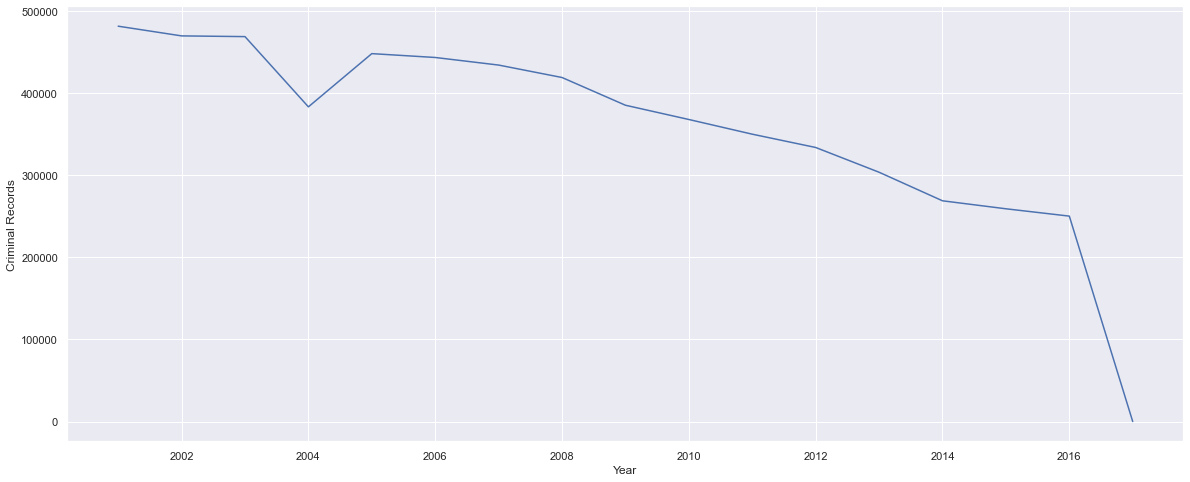

In [164]:
plt.figure(figsize = (20,8))
sns.set_theme(style="darkgrid")
sns.lineplot(crime_by_year.index, crime_by_year["value"])
plt.xlabel("Year")
plt.ylabel("Criminal Records")
plt.show()

## Plot crimes per day of the week

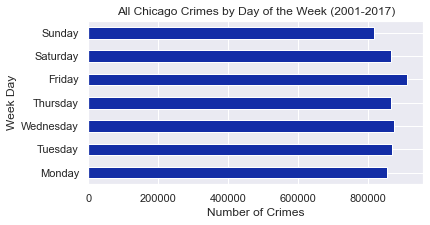

In [216]:
crimes_df = crimes_df.compute()
days = ['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes_df2 = crimes_df.groupby([crimes_df.index.dayofweek]).size()
crimes_df2.plot(kind='barh', figsize=(6,3), color='#132DA6')
plt.title('All Chicago Crimes by Day of the Week (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Week Day')
plt.yticks(np.arange(7), days)
plt.show()

## Plot crimes per month of the year

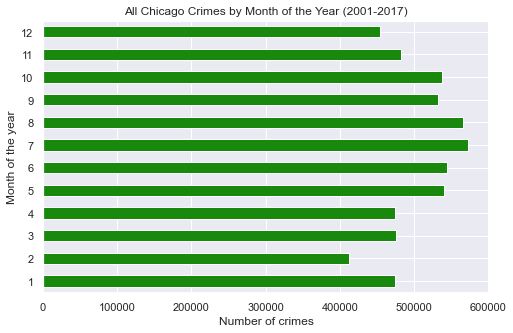

In [219]:
crimes_df.groupby([crimes_df.index.month]).size().plot(kind='barh', figsize=(8,5), color='#19890D')
plt.title('All Chicago Crimes by Month of the Year (2001-2017)')
plt.xlabel('Number of crimes')
plt.ylabel('Month of the year')
plt.show()

## Number of crimes per month (2001 - 2016)

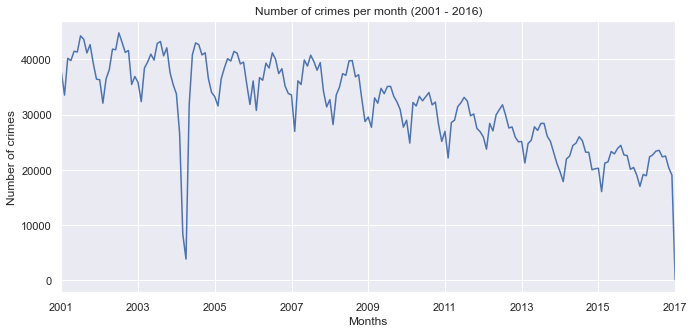

In [221]:
plt.figure(figsize=(11,5))
crimes_df.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2001 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

## Sum of all crimes throught the years

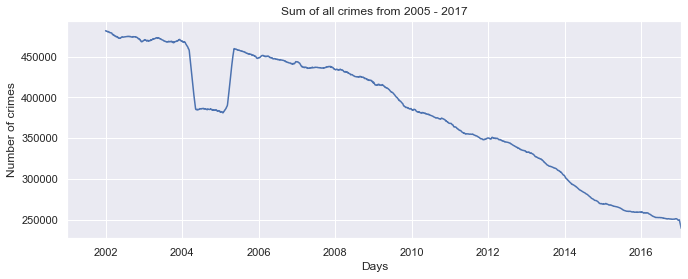

In [222]:
plt.figure(figsize=(11,4))
crimes_df.resample('D').size().rolling(365).sum().plot()
plt.title('Sum of all crimes from 2005 - 2017')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

## Plot monthly arrests

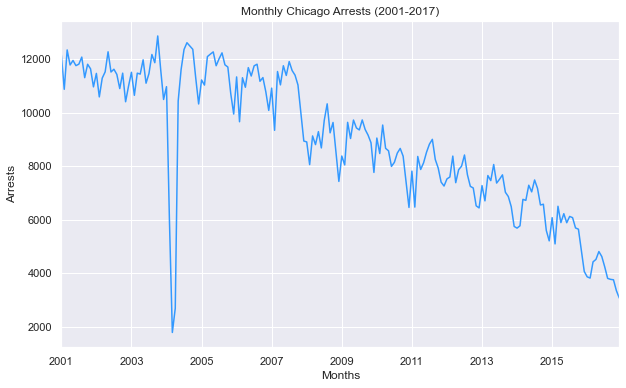

In [197]:
monthly_arrests = arrests.resample('M').sum()
monthly_arrests.plot(figsize=(10,6), color='#3399ff')
plt.title('Monthly Chicago Arrests (2001-2017)')
plt.xlabel('Months')
plt.ylabel('Arrests')
plt.show()

## Mapping Theft Crime Locations

In [50]:
Theft_Crimes = crimes_df.drop(columns=['Block', 'Domestic', 'Beat', 'District', 'Ward', 'FBI Code'], axis = 1)
Theft_Crimes = Theft_Crimes[Theft_Crimes["Primary Type"] == "THEFT"]
Theft_Crimes.head()

,Primary Type,Description,Location Description,Arrest,Community Area,Year,Latitude,Longitude
Date,,,,,,,,
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,46.0,2001.0,41.733539408,-87.547156
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,66.0,2001.0,41.777203808,-87.705942
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,OTHER,False,67.0,2001.0,41.789165627,-87.663084
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,71.0,2001.0,41.734716977,-87.654377
2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,68.0,2001.0,41.765053677,-87.641686


In [66]:
locations = Theft_Crimes.groupby('Community Area').first()
new_locations = locations.loc[:, ['Latitude', 'Longitude']]
new_locations.head()

,Latitude,Longitude
Community Area,,
0.0,41.799089601,-87.790549
1.0,42.015277064,-87.683162
2.0,41.99876544,-87.683672
3.0,41.972573024,-87.652114
4.0,41.962879197,-87.675896


In [223]:
MapOfChicago = folium.Map(location=[41.881832, -87.623177], zoom_start=11)
i=0
for index, row in new_locations.iterrows():
    folium.Marker(location = [row['Latitude'], row['Longitude']]).add_to(MapOfChicago)

MapOfChicago

# Summary: Overall number of cases per Year x Months using Heatmap

In [235]:
crimes_df2 = pd.DataFrame(crimes_df.resample("M").size(), columns=["Number of cases"])
crimes_df2["Month"] = crimes_df2.index.month.astype(str)
crimes_df2["Year"] = crimes_df2.index.year.astype(str)
crimes_df2["Year-Month"] = crimes_df2["Year"].str.cat(crimes_df2["Month"].str.zfill(2), sep="-")
crimes_df2.head()

,Number of cases,Month,Year,Year-Month
Date,,,,
2001-01-31,37800,1,2001,2001-01
2001-02-28,33539,2,2001,2001-02
2001-03-31,40200,3,2001,2001-03
2001-04-30,39802,4,2001,2001-04
2001-05-31,41491,5,2001,2001-05


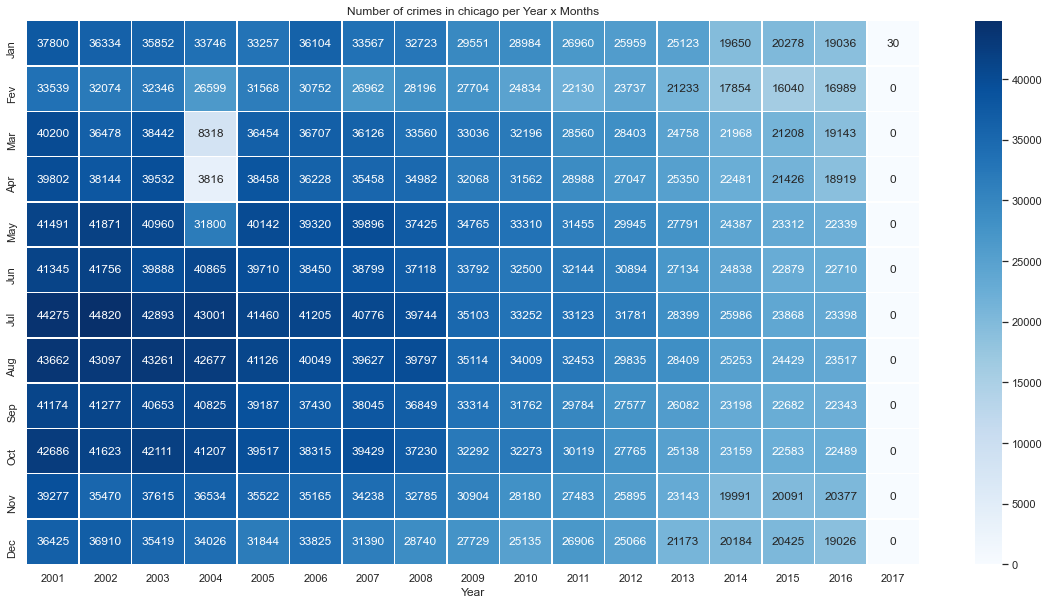

In [236]:
crimes_df3 = crimes_df2[["Month", "Year", "Number of cases"]]
crimes_df3 = crimes_df3.pivot("Month", "Year", "Number of cases").fillna(0).astype(int)
crimes_df3.index = crimes_df3.index.astype(int)
crimes_df3 = crimes_df3.sort_index()
crimes_df3.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(20, 10))
_ = sns.heatmap(
    crimes_df3,
    annot=True,
    fmt="d",
    linewidths=0.5,
    cmap="Blues",
).set_title('Number of crimes in chicago per Year x Months')

The years between 2001 and 2008 were a tough time